In [1]:
# パッケージ
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, SimpleRNN, GRU
from keras import optimizers
from keras.callbacks import EarlyStopping

2023-05-30 23:54:55.788594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 23:54:56.386379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
target_data = pd.read_csv("./target/target_USDJPY.csv")
#----OPTIONS----
unitsRNN      = 120
learning_rate = 0.0001
patience      = 10
epochs        = 2000
batch_size    = 30
maxlen = 90
print(target_data["date"].values[0])

2015.01.02


In [3]:
'''
1. データの準備
'''

# x = [target_data["deviation_rate"][i:i+maxlen].values for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen)]
x = []
for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen):
    d = []
    h = []
    l = []
    for j in range(maxlen):
        d.append(target_data["deviation_rate"].values[i+j])
        h.append(target_data["high"].values[i+j]/target_data["close"].values[i+j])
        l.append(target_data["low"].values[i+j]/target_data["close"].values[i+j])
    ilist = pd.DataFrame(data={
        "deviation_rate": d,
        "high": h,
        "low": l
    })
    x.append(ilist)
t = [ target_data["rise_rate"][i+maxlen-1] for i in range(59, len(target_data["rise_rate"].values[:])-maxlen)]

x = np.array(x).reshape(-1, maxlen, 3)
t = np.array(t).reshape(-1, 1)
print(x.shape, t.shape)

x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.2, shuffle=False)

(18162, 90, 3) (18162, 1)


In [4]:
'''
2. モデルの構築
'''
model = Sequential()
model.add(LSTM(unitsRNN, activation='tanh',
                recurrent_activation='sigmoid',
                kernel_initializer='he_normal',
                recurrent_initializer='orthogonal'))
model.add(Dense(1, activation='linear'))
model.add(Activation('tanh'))

2023-05-30 23:55:24.764786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 23:55:24.784376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 23:55:24.784447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 23:55:24.786980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 23:55:24.787061: I tensorflow/compile

In [5]:
'''
3. モデルの学習
'''
optimizer = optimizers.Adam(learning_rate=learning_rate,
                              beta_1=0.9, beta_2=0.999, amsgrad=True)

model.compile(optimizer=optimizer,
            loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',
                patience=patience,
                verbose=1)

hist = model.fit(x_train, t_train,
                epochs=epochs, batch_size=batch_size,
                verbose=2,
                validation_data=(x_val, t_val),callbacks=[es])

Epoch 1/2000


2023-05-30 23:55:26.209950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 23:55:26.211733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 23:55:26.213079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

485/485 - 9s - loss: 1.0073 - val_loss: 0.9699 - 9s/epoch - 18ms/step
Epoch 2/2000
485/485 - 6s - loss: 0.9901 - val_loss: 0.9653 - 6s/epoch - 13ms/step
Epoch 3/2000
485/485 - 6s - loss: 0.9901 - val_loss: 0.9702 - 6s/epoch - 13ms/step
Epoch 4/2000
485/485 - 6s - loss: 0.9900 - val_loss: 0.9697 - 6s/epoch - 13ms/step
Epoch 5/2000
485/485 - 6s - loss: 0.9900 - val_loss: 0.9670 - 6s/epoch - 13ms/step
Epoch 6/2000
485/485 - 6s - loss: 0.9899 - val_loss: 0.9700 - 6s/epoch - 13ms/step
Epoch 7/2000
485/485 - 6s - loss: 0.9898 - val_loss: 0.9714 - 6s/epoch - 13ms/step
Epoch 8/2000
485/485 - 7s - loss: 0.9898 - val_loss: 0.9647 - 7s/epoch - 14ms/step
Epoch 9/2000
485/485 - 6s - loss: 0.9896 - val_loss: 0.9642 - 6s/epoch - 12ms/step
Epoch 10/2000
485/485 - 6s - loss: 0.9897 - val_loss: 0.9747 - 6s/epoch - 12ms/step
Epoch 11/2000
485/485 - 6s - loss: 0.9895 - val_loss: 0.9682 - 6s/epoch - 12ms/step
Epoch 12/2000
485/485 - 6s - loss: 0.9892 - val_loss: 0.9619 - 6s/epoch - 13ms/step
Epoch 13/2000


 23/568 [>.............................] - ETA: 2s

2023-05-31 00:01:18.382351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 00:01:18.384041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 00:01:18.385288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

568/568 [==============================] - 3s 5ms/step


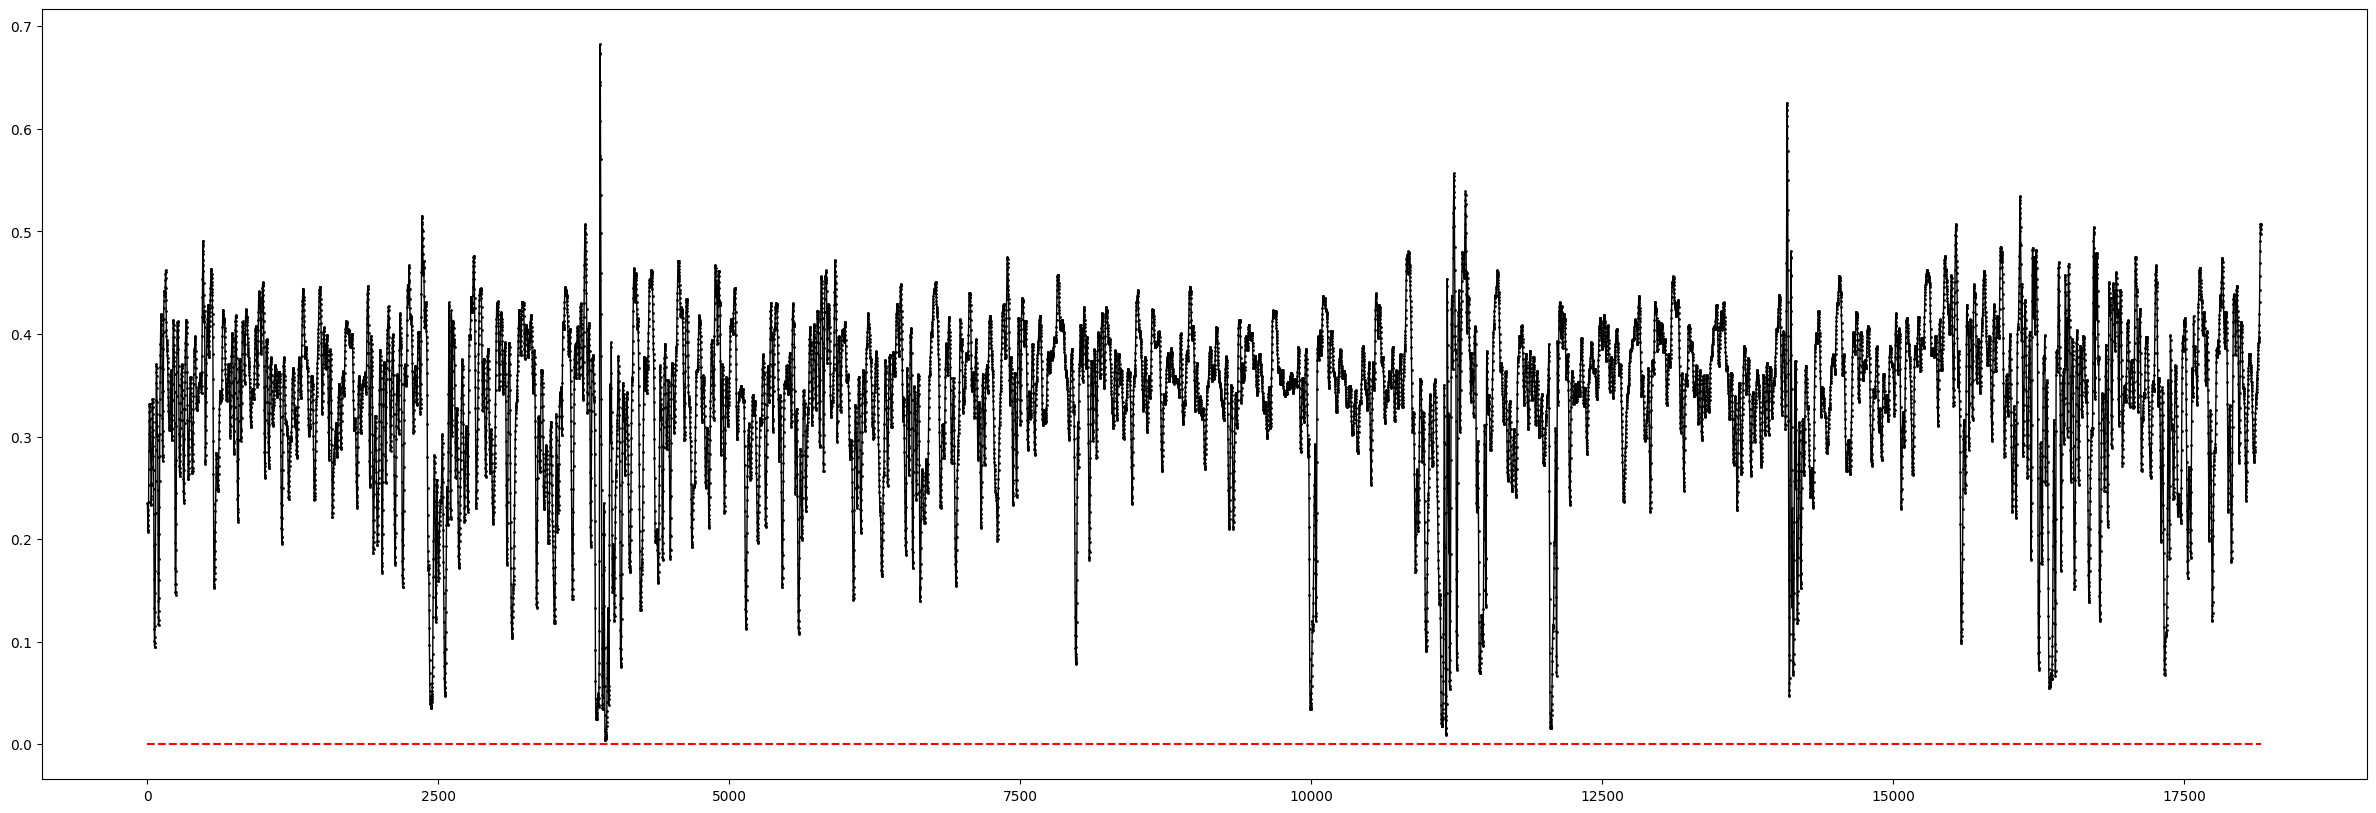

In [6]:
'''
4. モデルの評価
'''
indata = t
predicted = []

preds = model.predict(x)
for i in range(len(preds)):
    predicted.append(preds[i])

# 予測値を可視化
fig = plt.figure(figsize=(30, 10))
plot_length = len(predicted)
plt.plot(range(plot_length), predicted[:plot_length],
        color='black', linewidth=1,
        marker='o', markersize=1, markerfacecolor='black',
        markeredgecolor='black')
plt.plot([0, plot_length],[0, 0], "red", linestyle='dashed')
plt.show()

In [7]:
len(predicted)

18162

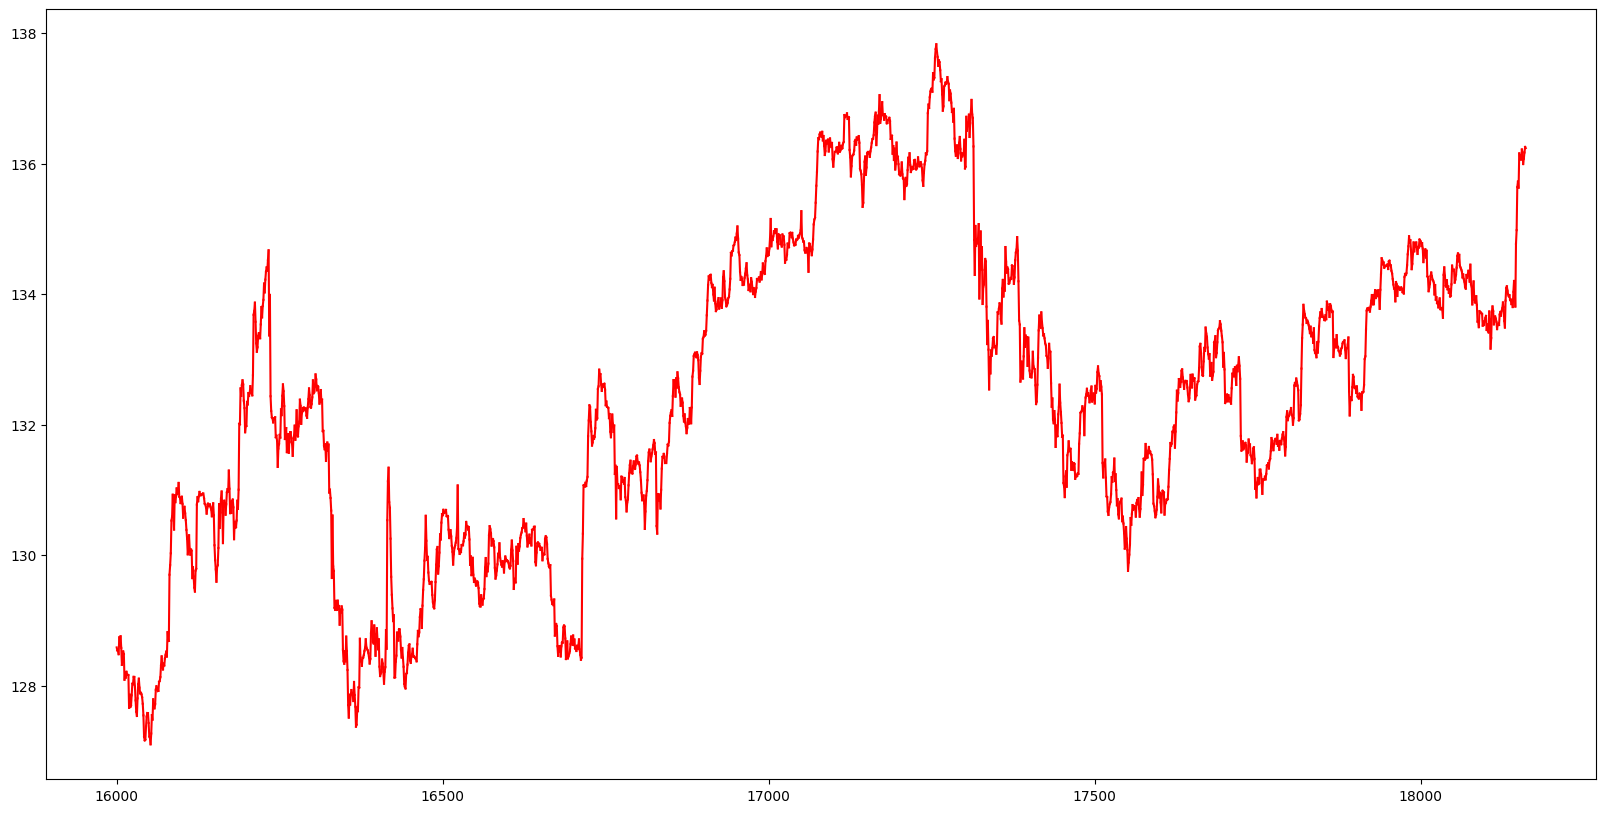

In [8]:
# 実データに反映し描画
chart = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
fig = plt.figure(figsize=(20,10))
plot_length = len(chart)
for i in range(16000,plot_length-1):
    plt.plot(range(plot_length+1)[i:i+2], chart[i:i+2], color= 'red' if predicted[i] > 0 else 'blue')
plt.show()

In [9]:
# 売買シミュレーション
#---OPTIONS---
total   = 100000     # 初期金額
per     = 0.1       # 1回の投資金額
per_lot = 100000     # 1ロット当たりの通貨数
leverage = 100        # レバレッジ(整数)
losscut = 0.998     # ロスカットする比率
position = None     # ポジションの状態（"Buy","Sell",None）買い,売り,無し
position_data = None  # 現在のポジションの情報[index, 取引時価格, lot数]
recent_position = None # 直近のポジション
result_history = [] # シミュレーションの結果を記録
win     = 0         # ポジションを変更したときに利益がプラスの回数
lose    = 0         # ポジションを変更したときに利益がマイナスの回数
tax     = 0         # 支払った税金
lscount = 0         # ロスカットの回数

chart = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
chart_high = [target_data["high"][i+maxlen-1] for i in range(59, len(target_data["high"].values[:])-maxlen)]
chart_low = [target_data["low"][i+maxlen-1] for i in range(59, len(target_data["low"].values[:])-maxlen)]
for i in range(len(predicted)-4000, len(predicted)):
    flag_losscut = False
    # ロスカット計算
    if position in ["Buy", "Sell"]:
        if position == "Buy":
            if position_data[1] * losscut > chart_low[i]:
                #total += (chart[i] - position_data[1]) * position_data[2] * per_lot
                total -= position_data[1] * (1-losscut) * position_data[2] * per_lot
                print(position_data[1] * (1-losscut) * position_data[2] * per_lot)
                flag_losscut = True
        
        elif position == "Sell":
            if position_data[1] * (2-losscut) < chart_high[i]:
                #total += (position_data[1] - chart[i]) * position_data[2] * per_lot
                total -= position_data[1] * (1-losscut) * position_data[2] * per_lot
                flag_losscut = True
    
    # ロスカットがなければ取引実行
    if not flag_losscut:
        if position == None:
            if predicted[i] > 0:
                position = "Buy"
            else:
                position = "Sell"
            # if predicted[i] > 0 and recent_position != "Buy":
            #     position = "Buy"
            # elif recent_position != "Sell":
            #     position = "Sell"
                
            # 何ロット？
            lots = (total * per * leverage / chart[i]) / per_lot
            position_data = [i, chart[i], lots]
                
        elif position == "Buy":
            if predicted[i] < 0 or (chart[i] - position_data[1])/position_data[1] > 0.01:
                # 直前のポジションを決済
                profit = (chart[i] - position_data[1]) * position_data[2] * per_lot
                total += profit
                if profit > 0:
                    win += 1
                else:
                    lose += 1
                position = "Sell"
                # 何ロット？
                lots = (total * per * leverage / chart[i]) / per_lot
                position_data = [i, chart[i], lots]
                
        elif position == "Sell":
            if predicted[i] > 0 or (position_data[1] - chart[i])/position_data[1] > 0.01:
                # 直前のポジションを決済
                profit =(position_data[1] - chart[i]) * position_data[2] * per_lot
                total += profit
                if profit > 0:
                    win += 1
                else:
                    lose += 1
                position = "Buy"
                # 何ロット？
                lots = (total * per * leverage / chart[i]) / per_lot
                position_data = [i, chart[i], lots]
        else:
            print(ValueError)
    else:
        # print("losscut")
        recent_position = position
        position = None
        lose += 1
        lscount += 1
    
    # 記録
    result_history.append(total)

print(f"勝利：{win}")
print(f"敗北：{lose}")
print(f"ロスカット{lscount}")
print(f"最終金額：{total}")

2000.0000000000018
1960.0000000000016
1920.8000000000018
1882.3840000000018
1844.7363200000018
1807.8415936000017
1771.6847617280016
1736.2510664934414
1701.5260451635727
1874.9303655904475
1837.4317582786387
1800.6831231130661
1764.6694606508047
1729.3760714377886
1694.7885500090322
1660.8927790088514
1767.8556389097585
1732.4985261315633
1697.8485556089317
1824.3836023537012
1787.8959303066274
1752.1380117004946
1717.0952514664848
1864.0526696963145
1826.7716163023883
1977.786198961623
2896.1863123625367
2838.2625861152865
3078.791912832765
4027.5831906667704
3947.0315268534346
3868.090896316365
3790.729078390038
3714.914496822237
3640.6162068857916
3567.803882748077
3496.447805093116
3426.5188489912543
3357.9884720114287
3290.8287025711998
3225.012128519776
3488.8718353852264
3767.682169746124
3692.3285263512025
3618.481955824178
4339.706494280363
4252.912364394755
4167.85411710686
5447.394556085928
5338.446664964211
5231.677731664925
5127.0441770316265
5024.503293490994
4924.013227

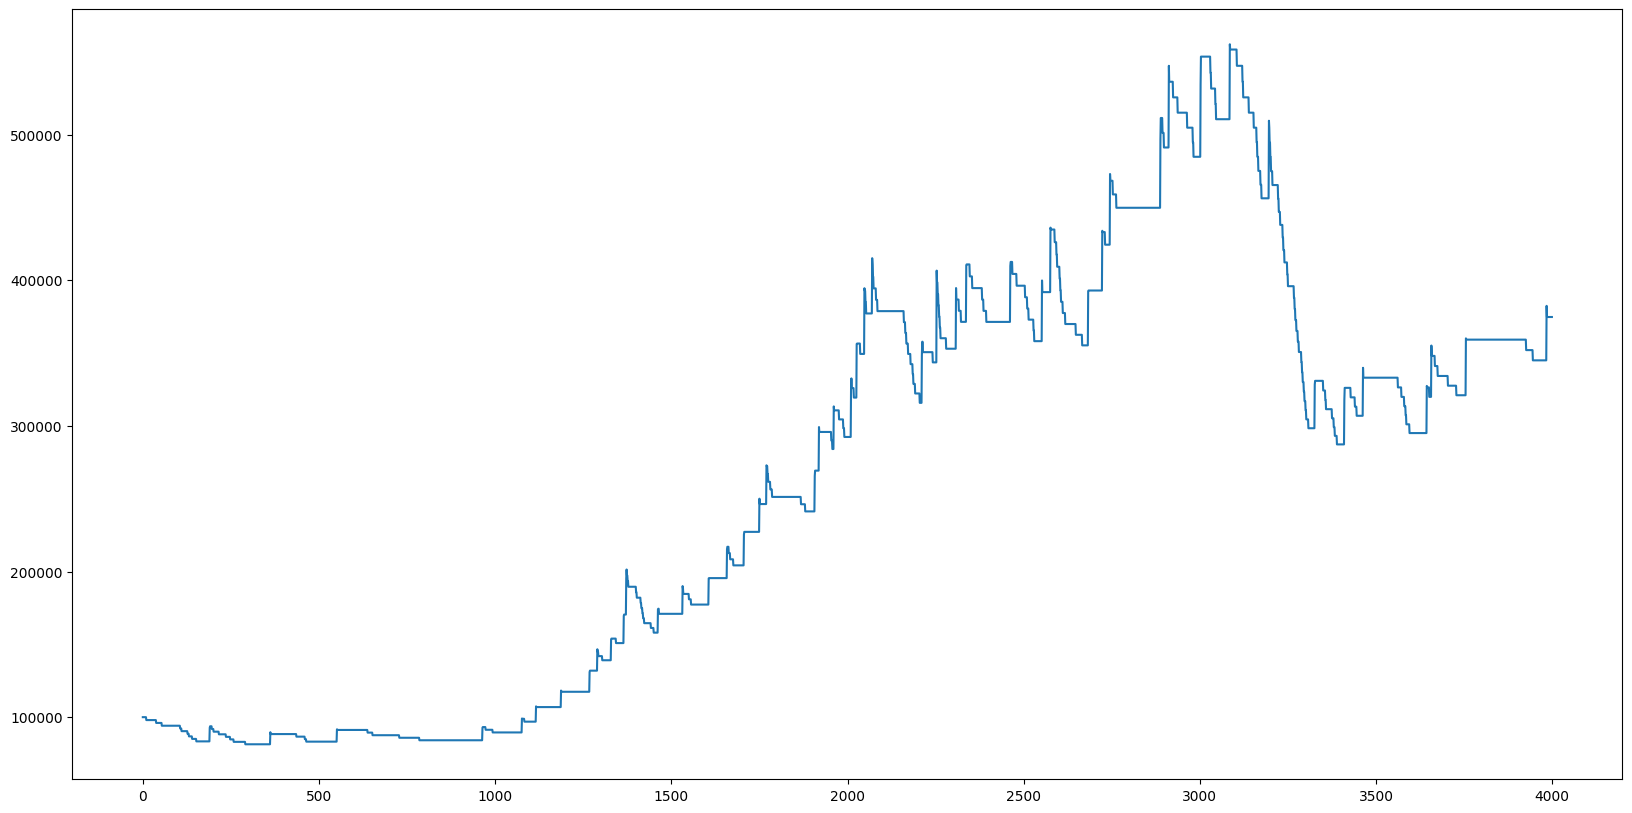

In [10]:
# シミュレーションの推移
fig = plt.figure(figsize=(20,10))
plt.plot(result_history)
plt.show()

In [11]:
# # 保存先がなければ作成
# dir_path = f"../models"
# dir = Path(dir_path)
# dir.mkdir(parents=True, exist_ok=True)
# # 現在の日時をつけて保存
# today = datetime.now()
# file_name = today.strftime("%Y%m%d_%H%M%S")
# model.save(f"{dir_path}/model{unitsRNN}_{maxlen}_{file_name}.h5")